In [1]:
from numpy import array, divide, multiply
from scipy.linalg import expm

pi_s = [0.298, 0.249, 0.232, 0.221]
PosRates = [3.821, 21.193, 2.615, 2.567, 34.546,   1   ]
             #γAC,    γAG,   γAT,   γCG,    γCT, γGT
A = []
for row in range(4):
    A.append([])
    for col in range(4):
        if row==col: A[row].append(0) # assign the diaganol a 0 value for now
        else: A[row].append(PosRates[(row+col)]*pi_s[col])
            
for row in range(4):
    rowSum = 0 
    for col in range(4): rowSum += A[row][col]
    A[row][row] = -rowSum

# A = [
#     [-(1/16.0)*3,  1/16.0,       1/16.0,             1/16.0            ],
#     [1/16.0,       -(1/16.0)*3,  1/16.0,             1/16.0            ],
#     [1/16.0,       1/16.0,       -((1/16.0)*2+.25),  .25               ],
#     [1/16.0,       1/16.0,       .25,                -((1/16.0)*2+.25) ],
# ]

scale = 0
A = array(A,dtype=object)
for N in range(4): scale += pi_s[N]*A[N][N]
A_s = -divide(A,scale)
A_s = array(A_s,dtype="float128")
A_s

array([[-0.80176924,  0.65586004,  0.07540134,  0.07050786],
       [ 0.78492487, -1.8078181 ,  0.0740173 ,  0.94887593],
       [ 0.09685172,  0.07944098, -0.20375973,  0.02746703],
       [ 0.09507395,  1.06909551,  0.02883416, -1.19300362]],
      dtype=float128)

In [2]:
N = 5
P_5 = expm(A_s * N *.01)
P_5

array([[0.96133201, 0.03084059, 0.00373826, 0.00408914],
       [0.03690962, 0.91535232, 0.00362577, 0.04411229],
       [0.00480174, 0.00389145, 0.98988102, 0.0014258 ],
       [0.00551386, 0.04970117, 0.00149677, 0.9432882 ]])

In [3]:
from scipy.stats import multinomial
seqMapper = {'1000':'A','0100':'C','0010':'G', '0001':'T'} # Single base generations
rv = multinomial.rvs
def randBase(pVals):
    base = rv(1,pVals)
    return seqMapper[''.join(str(v) for v in base)]

baseIndex = {'A':0,'C':1,'G':2,'T':3} # for converting bases into matrix coords
def simulateAlignSeqs(alnLen, P_N, pi_s):
    seq1, seq2 = "", ""
    for i in range(alnLen):
        seq1+=randBase(pi_s)
        coord = baseIndex[seq1[-1]]
        seq2 += randBase(P_N[coord])
    return seq1,seq2

In [4]:
fh = open("SimulatedSeqs.fasta","w")
seqs = {}
for length in [50,100,1000]:
    seq1,seq2 = simulateAlignSeqs(length,P_5, pi_s)
    seqs[length] = [[seq1,seq2]]  
    fh.write(">P%i_Seq1_%i\n%s\n" % (N,length,seq1))
    fh.write(">P%i_Seq2_%i\n%s\n" % (N,length,seq2))
fh.close()

# Question 1c - $P^{2N}$

In [5]:
N=10
P_20 = expm(A_s*2*N*.01)

In [6]:
fh = open("SimulatedSeqs.fasta","a")
for length in [50,100,1000]:
    seq1,seq2 = simulateAlignSeqs(length,P_20, pi_s)
    seqs[length].append([seq1,seq2]) 
    fh.write(">P%i_Seq1_%i\n%s\n" % (N,length,seq1))
    fh.write(">P%i_Seq2_%i\n%s\n" % (N,length,seq2))
fh.close()

In [7]:
%%bash
cat SimulatedSeqs.fasta

>P5_Seq1_50
TTACAGTGCCCTCAGCTTACCCACAAAGCGCATAGGGTAATGCTCGTATT
>P5_Seq2_50
TTACAGTGCCCTCAGCTTACCCACAAAGCGCATAGGGTAATGCTCGTATT
>P5_Seq1_100
CACTGCAAATTACATGTCCTGATGTAGTACCCATCAACCCGCGAAACCACGACCAGGAGCTCGACCTCAACTTACCGAGACAAGTGTGTCACTGCAGAGG
>P5_Seq2_100
CACTGTAAAATACATGTCCTGACGTAGTATACATCAACCCGCGAAACCACGACCAGGAGCCCGCCCTCAACTCACCGAGACAAGTGTGCCACTGCAGCGG
>P5_Seq1_1000
AGTAGCCGACCTCGAATCTAACACCGAGACCAAGCCTAGGAAGGGTCAATGAGGCGTTTTTTGCGCAGCAGCTTAGAATCTATGACTAGGCGAGTGGGTTGGTATTCGCAGCCAGTTTGATCACTCGCCTACTAGAGGCTCGCTCCCATGCACTCTTGGTGGAGTTCCATTAAGGTGCCTGCATAACGCAGGAGTAACGAGCAAATCGAAAAAAGAAGTTAGCAGGTAGTTCCATACCGAGAAATGCAGGCAAAAGCCCCGCCTATCATAAGGAGGCATTTAACTACACAGGAGTCGGGACTTATGGGATGAGCACCAGAACCGGCAGGGAAGTCACAGAAGAATAAGATATGCAGACCTCATAATTGCGGGTAATCTGGGCAATATGTTGCTGTCTACTATTTTAATTTTCGCTAAAGGAGGAACGTGGTCGTCAGCCTACTATTTATAAGGCGGGGTCCCGAGCTTAGAGTCACACAACCCGTCAGCGTACTTTCACAAATCATGCGTAACCACCACAACTCGCCCACTCTGGATGAACGCGTACGTGATAGAGTTAACGAGGACCCTCCATGTATGAGTTAAATTAACGGCTGCAGAGGGGAAGGAAATCCGCAAACACAGTGTTGCAC

# Question 2

#### STep 1. Create scoring matrix S

In [8]:
def calcPercIdent(seq1, seq2):
    matches = 0
    for i in range(len(seq1)):
        matches += int(seq1[i] == seq2[i])
    return matches/float(len(seq2))

In [9]:
avg = 0.0
wavg = 0.0
for length in seqs:
    for seq1, seq2 in seqs[length]:
        pIdent = calcPercIdent(seq1,seq2)
        wavg += pIdent*length
        avg+=pIdent
        print(length,pIdent)
print(avg/6.0*100, wavg/2300.0*100)

50 1.0
50 0.82
100 0.9
100 0.82
1000 0.954
1000 0.844
88.96666666666667 89.6086956521739


In [10]:
bases = ['A','C','G','T']
S = {}
scoreMat = []
for base1 in bases:
    S[base1] = {}
    scoreMat.append([])
    for base2 in bases:
        if base1 == base2: val = 2.0
        else: val = -3.0
        scoreMat[-1].append(val)
        S[base1][base2] = val
S

{'A': {'A': 2.0, 'C': -3.0, 'G': -3.0, 'T': -3.0},
 'C': {'A': -3.0, 'C': 2.0, 'G': -3.0, 'T': -3.0},
 'G': {'A': -3.0, 'C': -3.0, 'G': 2.0, 'T': -3.0},
 'T': {'A': -3.0, 'C': -3.0, 'G': -3.0, 'T': 2.0}}

#### Step 1. Calculate C, $\lambda$, A

In [11]:
%load_ext rpy2.ipython

In [12]:
scoreMat = array(scoreMat)
pi_s = array(pi_s)

In [13]:
%%R -i scoreMat -i pi_s -o lambduh -o C -o A
library(expm, quietly = T, warn.conflicts = F)
S = scoreMat

# Compute lambda
f <- function(t, pi, S) { sum(diag(pi) %*% exp(t*S) %*% diag(pi)) - 1} # moment generating function m_S(t)
lambduh <- uniroot(f, interval=c(1e-5,2), pi=pi_s, S=S)$root # compute lambda: the root is near 0

S <- as.vector(scoreMat) # the scoring matrix
prob <- as.vector(pi_s %*% t(pi_s)) # score probabilities under H0 
n.rep <- 100000 # no. of simulation replicates
H <- rep(0, n.rep) # excursion heights
L <- rep(-1, n.rep) # excursion lengths
Qt <- rep(0, max(S)) # prob first positive integer visited
R <- rep(0, -min(S)) # prob score at excursion end
score <- 0 # current excursion score, initial 0

i <- 1
while (i < n.rep) {
    score <- score + sample(S, size=1, prob=prob) # sample score under H0
    L[i] <- L[i] + 1 # and length
    if (score > 0 & L[i] == 0) { Qt[score] <- Qt[score] + 1 } # first positive value visited
    if (H[i] < score) H[i] <- score # record maximal height
    if (score < 0) {  # if score drops below 0, the excursion ends: reset
        R[-score] <- R[-score] + 1
        i <- i + 1 # next excursion
        score <- 0 # reset score to 0
    }
}
 # estimate probabilities and associated constants
R <- R/n.rep
Qt <- Qt/n.rep
Q.bar <- 1 - sum(Qt, na.rm=T) # prob. no positive value visited 
C <- Q.bar*(1 - sum(R * exp(-lambduh * 1:length(R)), na.rm=T)) / (1 - exp(-lambduh)) / sum(1:length(Qt)*Qt*exp(1:length(Qt)*lambduh), na.rm=T)
A <- -sum(1:length(R)*R, na.rm=T)/sum(S * prob) 

In [14]:
lambduh = lambduh[0]
AvgExcLen = A[0]
C = C[0]

In [15]:
from numpy import exp
def M(y,C,lambduh,A,n):
    return (n*C*exp(-lambduh*y))/A

In [16]:
for length in seqs:
    score = [0]
    for seq1, seq2 in seqs[length]:
        print(seq1)
        print(seq2)
        #Calculate the score
        minScore = 0
        ladder = [True]
        for i in range(length):
            b1,b2 = seq1[i],seq2[i]
            score.append(score[i]+S[b1][b2])

            #Calc Ladder
            if score[-1] <= minScore: 
                ladder.append(True)
                minScore = score[-1]
            else:
                ladder.append(False)

        #Calc excursion height
        maxExcHeight = 0
        baseline = 0
        for i in range(length+1):
            if ladder[i]: baseline = score[i]
            maxExcHeight = max(maxExcHeight, score[i]-baseline)

        # Calculate E[M(y) | M]
        print(length,M(maxExcHeight,C,lambduh, AvgExcLen,length)  )

TTACAGTGCCCTCAGCTTACCCACAAAGCGCATAGGGTAATGCTCGTATT
TTACAGTGCCCTCAGCTTACCCACAAAGCGCATAGGGTAATGCTCGTATT
50 1.5838627717786723e-26
TTTTGGCCCCATTGAAATTAAAGTTTACCATGACCATTCCGCTCGCATAG
CTCTGGCCTCATTGAAACTAATGTTTAATATGACCATCCAGCTCGCATAG
50 5.534567084878927e-26
CACTGCAAATTACATGTCCTGATGTAGTACCCATCAACCCGCGAAACCACGACCAGGAGCTCGACCTCAACTTACCGAGACAAGTGTGTCACTGCAGAGG
CACTGTAAAATACATGTCCTGACGTAGTATACATCAACCCGCGAAACCACGACCAGGAGCCCGCCCTCAACTCACCGAGACAAGTGTGCCACTGCAGCGG
100 8.252678422873598e-40
TGTTTACGCAAGTGGAATGCAAGCGCGGCATTTCCATTTATAGTGCCCGGCATTATAAAAGAGAAACCACAACGACAACCCGGACTCTTCCATGTGACGT
TGCACACGTAAGTGGAATGCAAGCGCGCCATTTCAATTTCTAGTGACCGGCACTATATAACCGAAATCACAACGACAATCTGGAGTCTTACATGTGAAGT
100 8.252678422873598e-40
AGTAGCCGACCTCGAATCTAACACCGAGACCAAGCCTAGGAAGGGTCAATGAGGCGTTTTTTGCGCAGCAGCTTAGAATCTATGACTAGGCGAGTGGGTTGGTATTCGCAGCCAGTTTGATCACTCGCCTACTAGAGGCTCGCTCCCATGCACTCTTGGTGGAGTTCCATTAAGGTGCCTGCATAACGCAGGAGTAACGAGCAAATCGAAAAAAGAAGTTAGCAGGTAGTTCCATACCGAGAAATGCAGGCAAAAGCCCCGCCTATCATAAGGAGGCATTTAACTACAC

# Homework Questions

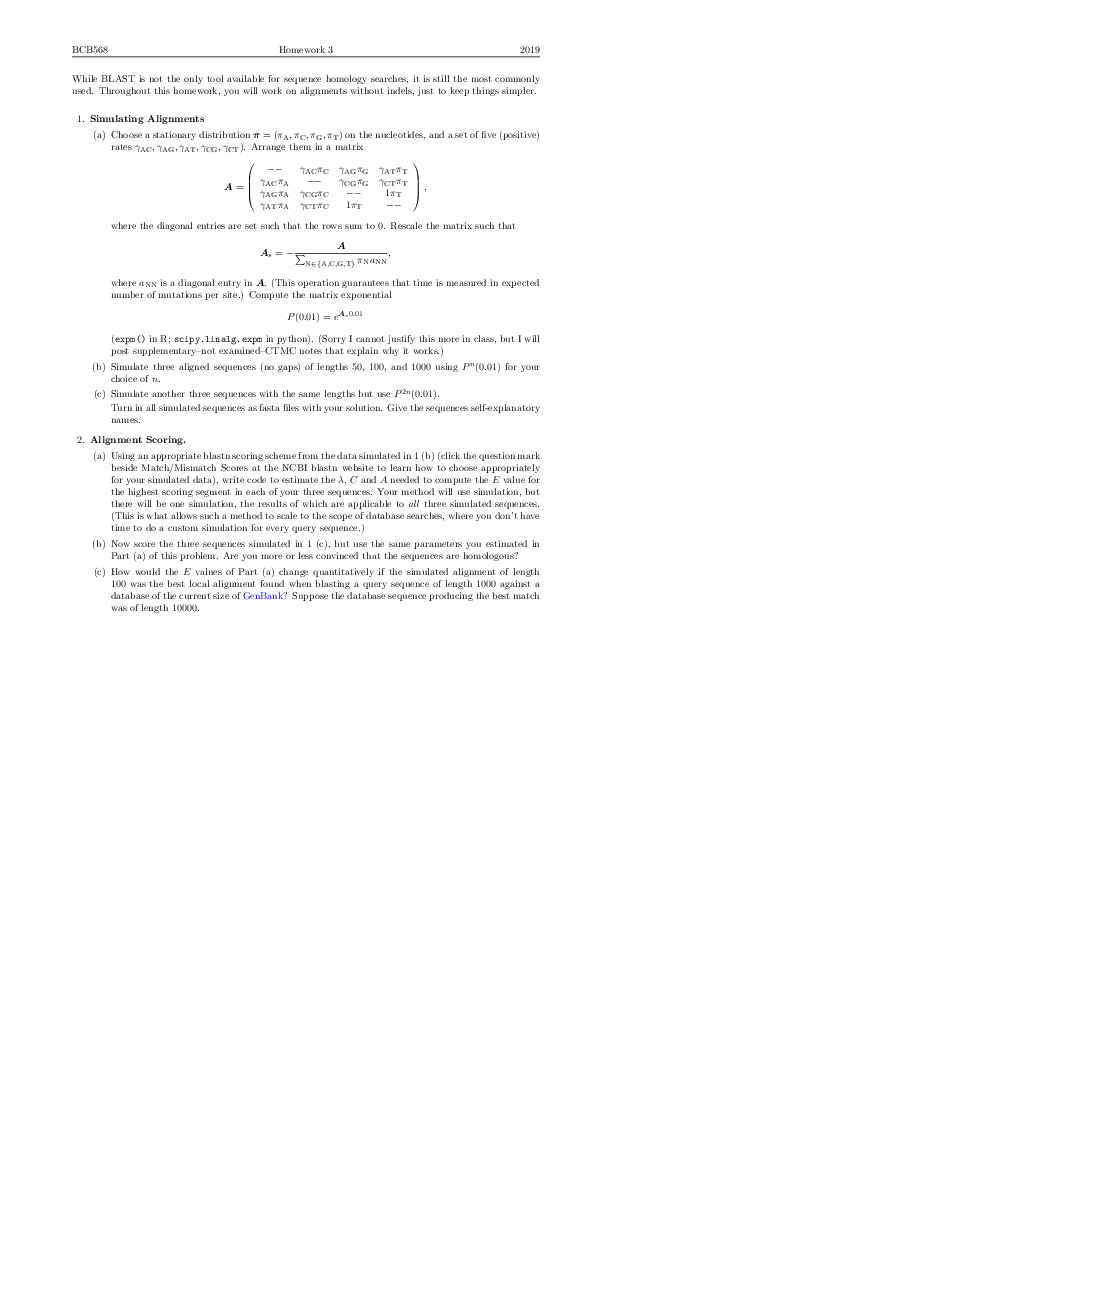

In [7]:
%matplotlib inline
from IPython.display import display, Image
from wand.image import Image as WImage #Comment this out if you don't need to display a NEW PDF; pip install Wand; conda install -c conda-forge ghostscript

imageFromPdf = WImage(filename='blast.pdf')  
pages = len(imageFromPdf.sequence)  
image = WImage( width=imageFromPdf.width+500, height=(imageFromPdf.height + 500) * pages)  
for i in range(pages):  image.composite(imageFromPdf.sequence[i], top=imageFromPdf.height * i, left=0)  
image.format="png"  
image 